## Selectivenet

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import numpy as np
from numpy.random import seed
seed(3)
tf.random.set_seed(3)
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation, Input
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import backend as K

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle
import seaborn as sns

### Model definition

In [2]:
class SelectiveNet:
    def __init__(self,dropout=0.2, mc_dropout = 0.2,num_classes=10,
               training=True, input_dim=(224,224,3),pooling="avg"):
        self.c = 0.75
        self.lamda = 32
        self.alpha = 0.5
        self.dropout = dropout
        self.mc_dropout = mc_dropout
        self.pooling = pooling
        self.input_dim = input_dim
        self.training = training
        self.num_classes = num_classes
        
        #create model
        inputs=Input(shape=self.input_dim)
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
        base_model.trainable=True
        x = base_model.output
        x = Dropout(self.dropout, name='top_dropout_1')(x,training=self.training)
        if pooling == 'avg':
            x = GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D(name='max_pool')(x)   
        x = Dropout(self.dropout, name='top_dropout_2')(x,training=self.training)
        x = Dense(512,activation='relu', name='dense_512')(x)
        x = BatchNormalization()(x)
        x = Dropout(self.mc_dropout, name='top_dropout_3')(x,training=self.training)
        x = Lambda(lambda x: K.dropout(x, level=self.mc_dropout))(x)

        #classification head (f)
        f = Dense(self.num_classes,activation='softmax', name='f_head')(x)

        #selection head (g)
        g = Dense(512, activation='relu', name='dense_512_g')(x)
        g = BatchNormalization()(g)
        # this normalization is identical to initialization of batchnorm gamma to 1/10
        g = Lambda(lambda a: a / 10)(g)
        g = Dense(1, activation='sigmoid', name='g_head')(g)

        # auxiliary head (h)
        selective_output = Concatenate(axis=1, name="selective_head")([f, g])


        auxillary_output = Dense(self.num_classes,activation='softmax', name='auxilary_head')(x)


        self.model = Model(inputs=inputs,outputs=[selective_output,auxillary_output])
        
    
    def get_model(self):
        return self.model
    
    def set_model_weights(self,filename):
        self.model.load_weights(filename)
    
    def compile_model(self,c=0.75, lamda=32, alpha=0.5,tau=0.5,lr=0.01,decay=1e-6,momentum=0.9):
        self.c = c
        self.lamda = lamda
        self.alpha = alpha
        def coverage(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], tau), K.floatx())
            return K.mean(g)

        def selective_loss(y_true, y_pred):
            em_coverage = K.mean(y_pred[:, -1])
            loss = K.categorical_crossentropy(K.repeat_elements(y_pred[:, -1:], self.num_classes, axis=1) * y_true[:,:],
                    y_pred[:, :self.num_classes]) + self.lamda * K.maximum(-em_coverage+self.c,0) ** 2
            return loss

        def selective_acc(y_true, y_pred):
            g = K.cast(K.greater(y_pred[:, -1], tau), K.floatx())
            temp1 = K.sum(
                (g) * K.cast(K.equal(K.argmax(y_true[:,:-1], axis=1), K.argmax(y_pred[:, :-1], axis=1)), 
                             K.floatx()))
            temp1 = temp1 / K.sum(g)
            return K.cast(temp1, K.floatx())
    
        sgd = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
        self.model.compile(loss=[selective_loss, 'categorical_crossentropy'], loss_weights=[self.alpha, 1 - self.alpha],
                      optimizer=sgd, metrics=['accuracy', selective_acc, coverage])
    
    def model_train(self, train_ds, EPOCHS, val_ds=None, initial_epoch=0, shuffle=True, callbacks = [], 
                    verbose = 2):
        if(val_ds):
            history =self.model.fit(
                train_ds,
                initial_epoch=initial_epoch,
                epochs=EPOCHS,
                validation_data=val_ds,
                shuffle=shuffle,
                verbose = verbose,
                callbacks=callbacks
            )
        else:
            history = self.model.fit(
                train_ds,
                initial_epoch=initial_epoch,
                epochs=EPOCHS,
                shuffle=shuffle,
                verbose = verbose,
                callbacks=callbacks
            )
        return history         
            
    def classification_predict(self, test):
        predictions= self.model.predict(test)
        return predictions

    def mc_dropout(self,test_ds,iter=100):
        for i in range(iter):
            mc_predictions = self.classification_predict(test_ds)
        selective_head = np.mean(mc_predictions[0],1)
        classification_head =np.mean(mc_predictions[1],1)
        return np.array([selective_head,classification_head])

    def selective_risk(self,c,y_true,y_pred):
        if(100*(1-c)<0):
            q = 0
        elif(100*(1-c)>100):
            q =100
        else:
            q =100*(1-c)
        threshold = np.percentile(y_pred[:,-1],q)
        covered_indx = y_pred[:, -1] > threshold
        g = covered_indx.astype('int')
        coverage = np.mean(g)
        acc = np.sum( np.equal( np.argmax(y_pred[:, :self.num_classes],axis=1), 
                                 np.argmax(y_true[:, :-1], axis=1))) / np.sum(g)

        risk = 1-acc
        return coverage, risk, acc

    def sr_selective_risk(self,c, y_true, y_pred):
       
        sr = np.max(y_pred[:,:self.num_classes], axis=1)
        sr_sorted = np.sort(sr)
        threshold = sr_sorted[sr.shape[0] - int(c * sr.shape[0])]
        covered_indx = sr > threshold
        g = covered_indx.astype('int')
        coverage = np.mean(g)
        acc = np.sum( np.equal( np.argmax(y_pred[:, :self.num_classes],axis=1), 
                                 np.argmax(y_true[:, :-1], axis=1))) / np.sum(g)
        risk = 1-acc
        return coverage, risk, acc

### Softmax model

In [3]:
def SR_model(num_classes, dropout,mc_dropout, input_dim, training, pooling='avg'):
    inputs=Input(input_dim)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable=True
    x = base_model.output
    x = Dropout(dropout, name='top_dropout_1')(x,training=training)
    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='max_pool')(x)   
    x = Dropout(dropout, name='top_dropout_2')(x,training=training)
    x = Dense(512,activation='relu', name='dense_512')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout, name='top_dropout_3')(x,training=training)
    x = Lambda(lambda x: K.dropout(x, level=mc_dropout))(x)

    #classification head (f)
    sr = Dense(num_classes,activation='softmax', name='dense_f')(x) 
    return Model(inputs=inputs,outputs=sr)


### Load data

In [4]:
src_dir="../.keras/datasets/ISIC_2019_Training_Input"

### Split dataframe into k folds

In [5]:
def train_test_val(n,split_ratio, dataset, val=True):    
    rng=np.random.default_rng() #for reproducibility
    random_idx = rng.choice(n, size=n, replace=False) # returns a numpy array, shuffles the index based on n   
    test_end = int(split_ratio[1]*n)
    if(val):
        test_end = int(split_ratio[1]*n) // 2
        test_idx = random_idx[:test_end]
        val_idx = random_idx[test_end:(test_end*2)]
        train_idx = random_idx[(test_end*2):] 
        return dataset.iloc[train_idx,:], dataset.iloc[test_idx,:],dataset.iloc[val_idx,:]

    test_idx = random_idx[:test_end]
    train_idx = random_idx[test_end:]
    return dataset.iloc[train_idx,:], dataset.iloc[test_idx,:] 

def gen_class_idx(n):
    #returns idx for a dataset 
    rng=np.random.default_rng() #for reproducibility
    # returns a numpy array, shuffles the index based on number of images   
    random_idx = rng.choice(n, size=n, replace=False)
    return random_idx

def k_fold_split(k,dataframe):
    n = len(dataset)
    class_idx = gen_class_idx(n)
    fold_ds = list()
    start=0
    end=0
    idx =[]
    num_in_fold = n//k
    for i in range(k):
        end = num_in_fold*(i+1)
        if(num_in_fold<=0):
            idx =[]
        else:    
            if(i<(k-1)):
                idx = class_idx[start:end]
            else:
                idx = class_idx[start:]
        start = num_in_fold*(i+1)
        fold_ds.append(dataset.values[idx]) 
      
    return fold_ds     

In [6]:
class_df_num =np.array([[3166.,  678.,  678.],
       [9013., 1931., 1931.],
       [2327.,  498.,  498.],
       [ 607.,  130.,  130.],
       [1838.,  393.,  393.],
       [ 169.,   35.,   35.],
       [ 179.,   37.,   37.],
       [ 440.,   94.,   94.],
       [   0.,    0.,    0.]])

In [7]:
class_df_num

array([[3166.,  678.,  678.],
       [9013., 1931., 1931.],
       [2327.,  498.,  498.],
       [ 607.,  130.,  130.],
       [1838.,  393.,  393.],
       [ 169.,   35.,   35.],
       [ 179.,   37.,   37.],
       [ 440.,   94.,   94.],
       [   0.,    0.,    0.]])

### Save test, train, val

In [8]:
train_df=pd.read_csv('m_train.csv')
test_df=pd.read_csv('m_test.csv')
val_df=pd.read_csv('m_val.csv')

In [9]:
gt_columns=train_df.columns
classnames=gt_columns[1:]
classnames

Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')

In [10]:
class_ds_num = np.zeros((classnames.shape[0],1),dtype="float")
k_fold_ds = list()
k = 3


dataset = train_df[train_df[classnames[0]]==1.0]
n = len(dataset)
class_ds_num[0,:] = [n]
k_fold_ds = k_fold_split(k,dataset)

i=1
for classname in classnames[1:]:
    dataset = train_df[train_df[classname]==1.0]
    n = len(dataset)
    class_ds_num[i,:] = [n]
    class_fold_ds = k_fold_split(k,dataset)
    for j in range(k):
        k_fold_ds[j] = np.vstack((k_fold_ds[j],class_fold_ds[j]))
    i=i+1
#class_ds_num #k_fold_ds[4]    

In [41]:
# del train_df

In [42]:
# class_ds_num
# k_fold_ds[2].shape

### Load Dataset

In [11]:
def create_ds(ndarr):    
    df = pd.DataFrame(data=ndarr[:,1:],columns=gt_columns[1:],dtype='float')
    df[gt_columns[0]] = src_dir +"/" + ndarr[:,0] +".jpg"
    dataset = tf.data.Dataset.from_tensor_slices((df[gt_columns[0]].values, df[gt_columns[1:]].values))
    return dataset

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
def process_data(file_path,img_label):
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, img_label
   
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
#     ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [15]:
val_df['image'] = src_dir +"/" + val_df['image'] +".jpg"
val_df[classnames]=val_df[classnames].astype('float32')
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image'].values, val_df[classnames].values))
val_ds = val_ds.map(process_data, num_parallel_calls=AUTOTUNE)
val_ds=val_ds.batch(BATCH_SIZE)

### Train model

In [16]:
dropout = 0.2
mc_dropout =0.1
training=True
pooling="avg"
num_class=len(classnames)
input_dims=(224,224,3)
learning_rate = 0.01
momentum=0.9

lr_decay = 1e-6

lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Create callback for early stopping

In [17]:
early_stop_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True
)

In [18]:
save_dir='selectivenet'
# os.mkdir(save_dir)
history_header =",".join(["model_no","auxilary_head_accuracy","selective_head_accuracy", "selective_head_selective_acc", 
                  "loss","auxilary_head_loss", "selective_head_loss", "auxilary_head_coverage", 
                  "selective_head_coverage","val_auxilary_head_accuracy","val_selective_head_accuracy",
                  "val_selective_head_selective_acc", "val_loss","val_auxilary_head_loss", "val_selective_head_loss", 
                  "val_auxilary_head_coverage", "val_selective_head_coverage\n"])
history_fname=save_dir+'/sel_multiple_history3.csv'
# f=open(history_fname,"w")
# f.write(history_header)
# f.close()

In [19]:
#receives a list of strings
def write_csv(filename,recs):
    f=open(filename,"a+")
#     print(recs)
    recs=recs.astype('str')
    for rec in recs:
        f.write("%s\n" % ','.join(list(rec)))
    f.close()        

In [20]:
target_coverages = np.arange(0.7,1.0,0.05) #coverages

### Create models

In [21]:
models =[]
for cov in target_coverages:
    my_selectivenet = SelectiveNet(dropout=dropout, mc_dropout = mc_dropout,num_classes=num_class,
                               training=training, input_dim=input_dims,pooling=pooling)
    my_selectivenet.compile_model(c=cov,lr=learning_rate,decay=lr_decay)
    models.append(my_selectivenet)

In [22]:
no_models = len(models)

In [23]:
sr_model = SR_model(num_class, dropout=dropout, mc_dropout = mc_dropout, input_dim=input_dims, training=training, pooling=pooling)
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=momentum, nesterov=True)
sr_model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

Here models are trained one after the other

In [127]:
initial_epoch=0
EPOCHS = 5
model_no=6
j=0
while(EPOCHS<=90):
    for i in range(k):
        fold_ds = create_ds(k_fold_ds[i])
        ds_size = k_fold_ds[i].shape[0]
        STEPS_PER_EPOCH=ds_size/BATCH_SIZE
        fold_ds = fold_ds.map(process_data, num_parallel_calls=AUTOTUNE)
        fold_ds = prepare_batches(fold_ds,shuffle_buffer_size=ds_size)
        history = models[model_no].model_train(fold_ds, EPOCHS=EPOCHS, val_ds=val_ds, 
                                       initial_epoch=initial_epoch,shuffle=False,verbose=1, callbacks = [early_stop_callback,reduce_lr])
        a=np.vstack((np.full([len(history.history['auxilary_head_accuracy'])],[model_no]),
                     np.array([history.history['auxilary_head_accuracy'], history.history['selective_head_accuracy'],
                               history.history['selective_head_selective_acc'], history.history['loss'], history.history['auxilary_head_loss'],
                               history.history['selective_head_loss'], history.history['auxilary_head_coverage'],
                               history.history['selective_head_coverage'], history.history['val_auxilary_head_accuracy'],
                               history.history['val_selective_head_accuracy'], history.history['val_selective_head_selective_acc'], 
                               history.history['val_loss'], history.history['val_auxilary_head_loss'], 
                               history.history['val_selective_head_loss'], history.history['val_auxilary_head_coverage'], 
                               history.history['val_selective_head_coverage'] ]) )).T
        write_csv(history_fname,a)
        initial_epoch = EPOCHS
        EPOCHS = EPOCHS+5
models[model_no].get_model().save_weights(save_dir+'/model_'+str(model_no)+'.h5')        

### Load model weights

In [46]:
for model_no in range(no_models):
    models[model_no].set_model_weights(save_dir+'/model_'+str(model_no)+'.h5')

### SR training

In [26]:
header =",".join(["accuracy", "loss","val_accuracy","val_loss\n"])
sr_history=save_dir+'/sel_sr_history3.csv'
# f=open(sr_history,"w")
# f.write(header)
# f.close()

In [45]:
initial_epoch=0
EPOCHS = 5
j=0
while(EPOCHS<=100):
    for i in range(k):
        fold_ds = create_ds(k_fold_ds[i])
        ds_size = k_fold_ds[i].shape[0]
        STEPS_PER_EPOCH=ds_size/BATCH_SIZE
        fold_ds = fold_ds.map(process_data, num_parallel_calls=AUTOTUNE)
        fold_ds = prepare_batches(fold_ds,shuffle_buffer_size=ds_size)
        #now training sr model
        history = sr_model.fit(
            fold_ds,
            initial_epoch=initial_epoch,
            epochs=EPOCHS,
            shuffle=True,
            validation_data = val_ds,
            verbose = 2,
            callbacks = [early_stop_callback,reduce_lr]
        )
        a=np.array([
            history.history['accuracy'],
            history.history['loss'],
            history.history['val_accuracy'],
            history.history['val_loss']
        ]).T
        write_csv(sr_history,a)
        initial_epoch = EPOCHS
        EPOCHS = EPOCHS+5 
sr_model.save_weights(save_dir+'/model_sr.h5')        

### Load SR model weights

In [62]:
sr_model.load_weights(save_dir+'/model_sr.h5')

### Visualize training metrics

In [28]:
lr_curve=pd.read_csv(history_fname) ## lr_curve.dtypes

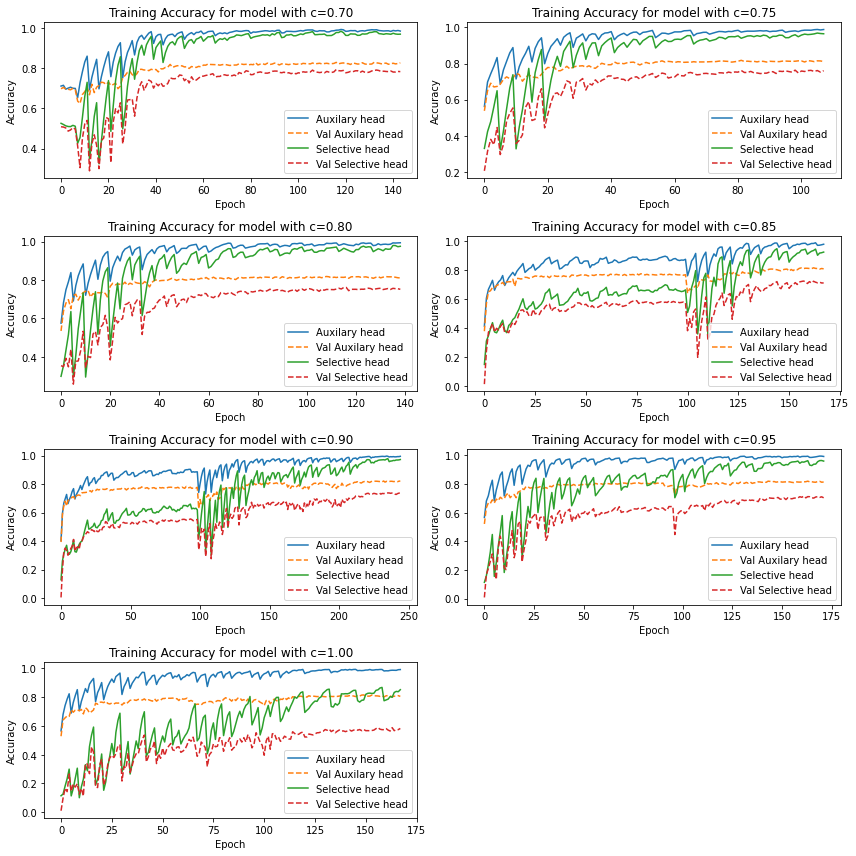

In [29]:
# target_coverages
plt.figure(figsize=(12,12))
for i in range(no_models):
    ax = plt.subplot(4,2,i+1)
    y = lr_curve[lr_curve['model_no']==i]
    x = np.arange(y.shape[0])
    #     print(y.shape)
    ax.plot(x,y['auxilary_head_accuracy'],linestyle='-', label='Auxilary head')
    ax.plot(x,y['val_auxilary_head_accuracy'],linestyle='--', label='Val Auxilary head')
    ax.plot(x,y['selective_head_accuracy'],linestyle='-', label='Selective head')
    ax.plot(x,y['val_selective_head_accuracy'],linestyle='--', label='Val Selective head')
    ax.legend(loc="best")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy for model with c={:.2f}'.format(target_coverages[i]))
plt.tight_layout()
plt.show()

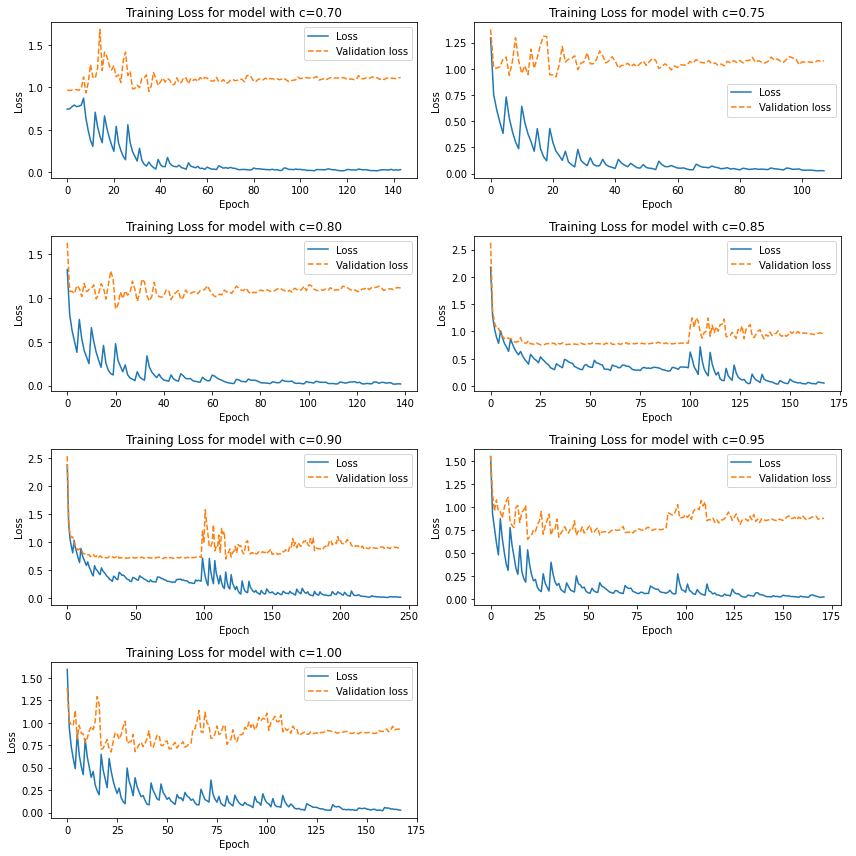

In [30]:
# target_coverages
plt.figure(figsize=(12,12))
for i in range(no_models):
    ax = plt.subplot(4,2,i+1)
    y = lr_curve[lr_curve['model_no']==i]
    x = np.arange(y.shape[0])
    #     print(y.shape)
    ax.plot(x,y['loss'],linestyle='-', label='Loss')
    ax.plot(x,y['val_loss'],linestyle='--', label='Validation loss')
    ax.legend(loc="best")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss for model with c={:.2f}'.format(target_coverages[i]))
plt.tight_layout()
plt.show()

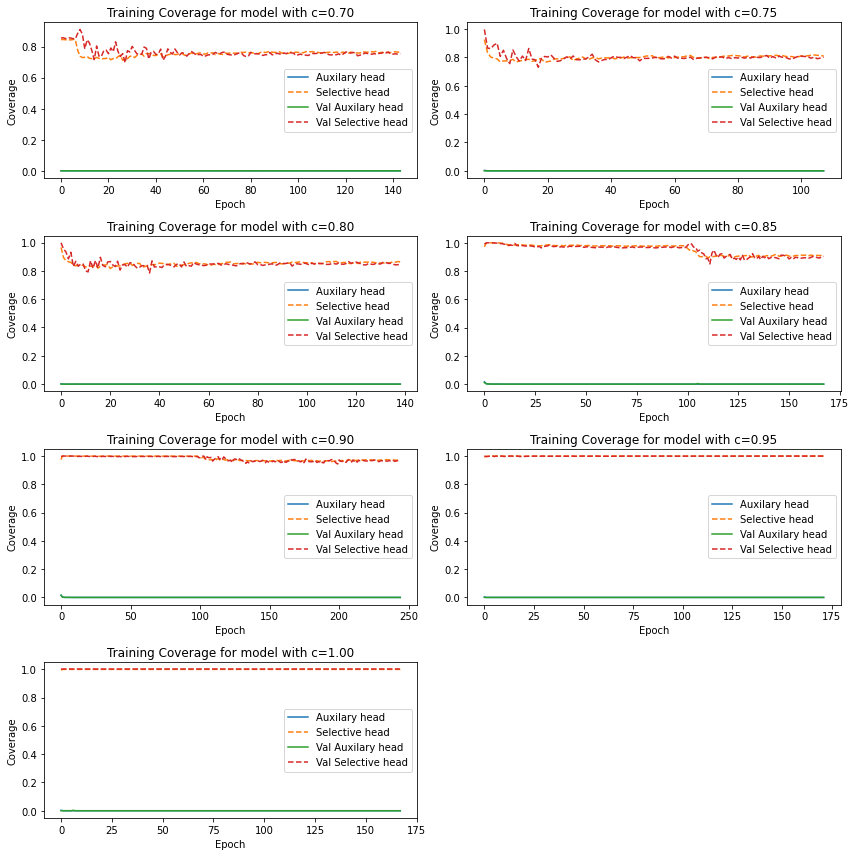

In [31]:
# target_coverages
plt.figure(figsize=(12,12))
for i in range(no_models):
    ax = plt.subplot(4,2,i+1)
    y = lr_curve[lr_curve['model_no']==i]
    x = np.arange(y.shape[0])
    #     print(y.shape)
    ax.plot(x,y['auxilary_head_coverage'],linestyle='-', label='Auxilary head')
    ax.plot(x,y['selective_head_coverage'],linestyle='--', label='Selective head')
    ax.plot(x,y['val_auxilary_head_coverage'],linestyle='-', label='Val Auxilary head')
    ax.plot(x,y['val_selective_head_coverage'],linestyle='--', label='Val Selective head')
    ax.legend(loc="best")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Coverage')
    ax.set_title('Training Coverage for model with c={:.2f}'.format(target_coverages[i]))
plt.tight_layout()
plt.show()

### SR learning curve

In [32]:
sr_curve=pd.read_csv(sr_history)

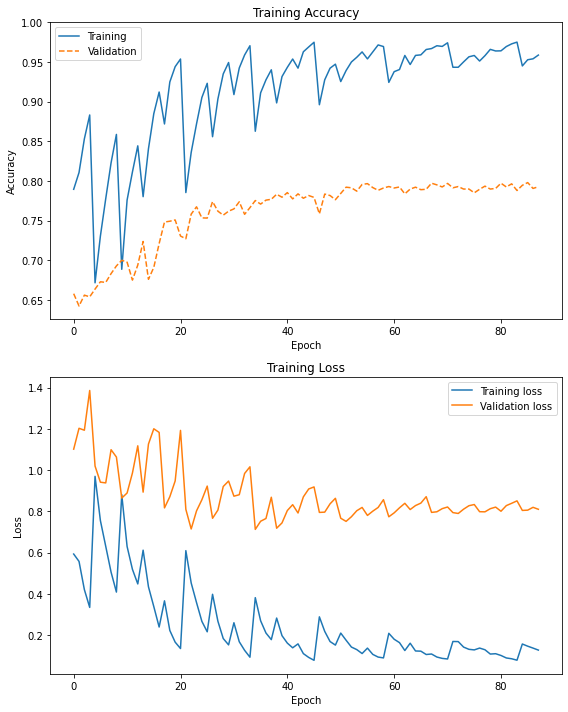

In [33]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
x = np.arange(sr_curve.shape[0])
plt.plot(x,sr_curve['accuracy'],linestyle='-', label='Training')
plt.plot(x,sr_curve['val_accuracy'],linestyle='--', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x,sr_curve['loss'], label='Training loss')
plt.plot(x,sr_curve['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [34]:
# del lr_curve

In [35]:
# del k_fold_ds
# del train_df
# del val_df

### Evaluate models

In [36]:
classes = {i:x for i,x in enumerate(classnames)} # classes

In [37]:
def my_evaluation(y_true,y_pred):
    acc=np.sum(np.equal(y_true,y_pred))/y_true.shape[0] #accuracy
    return(acc)

def plot_cm(y_true, y_pred,label):
    cm = confusion_matrix(y_true, y_pred,labels=label)
    return cm

def covered_idx(c,g):
    q =100*(1-c)
    if(q<0):
        q = 0
    elif(q>100):
        q =100
    threshold = np.percentile(g,q)
    covered_idx = g > threshold
    return covered_idx

def sr_covered_idx(c,y_true,y_pred):
    sr = np.max(y_pred, axis=1)
    sr_sorted = np.sort(sr)
    threshold = sr_sorted[sr.shape[0] - int(c * sr.shape[0])]
    covered_idx = sr > threshold
    return covered_idx

def selective_risk(c,y_true,y_pred,g):
    covered_indx = covered_idx(c,g)
    coverage = np.mean(covered_indx)
    acc = np.sum( np.equal( np.argmax(y_pred[covered_indx],axis=1), 
                             np.argmax(y_true[covered_indx], axis=1)))/np.sum(covered_indx)
    risk = 1-acc
    return coverage, risk,acc

def sr_selective_risk(c, y_true, y_pred, mc=False):
    if(mc):
        sr = np.max(y_pred, axis=1)
    else:
        sr = mc_dropout(100)
    sr_sorted = np.sort(sr) 
    threshold = sr_sorted[sr.shape[0] - int(c * sr.shape[0])]
    covered_idx = sr > threshold
    coverage = np.mean(covered_idx)
    selective_acc = np.sum(np.equal(np.argmax(y_pred[covered_idx], 1),
                                    np.argmax(y_true[covered_idx], 1)))/np.sum(covered_idx)
    risk = 1-selective_acc
    return coverage, risk, selective_acc

### Test dataset

In [38]:
test_df['image'] = src_dir +"/" + test_df['image'] +".jpg"
test_df[classnames]=test_df[classnames].astype('float32')

In [39]:
test_df['image'].head(1)

0    ../.keras/datasets/ISIC_2019_Training_Input/IS...
Name: image, dtype: object

In [40]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['image'].values, test_df[classnames].values))

In [41]:
total = int(np.sum(class_df_num[:,1]))
total

3796

In [42]:
test_ds = test_ds.map(process_data, num_parallel_calls=AUTOTUNE)
# # test_ds = test_ds.cache("drop_test_ds_cache.tmp")
test_ds=test_ds.batch(total)

In [43]:
test_batch,test_labels = next(iter(test_ds))

In [44]:
# del test_df

### Make predictions

In [47]:
test_labels.shape

TensorShape([3796, 9])

In [48]:
y_true = np.argmax(test_labels,axis=1)

In [49]:
model_preds=[]

In [50]:
for i in range(no_models):
    predictions= models[i].classification_predict(test_batch) #set predictions for use
    model_preds.append(predictions)
    acc=my_evaluation(y_true,np.argmax(predictions[0][:,:num_class],axis=1))
    aux_acc=my_evaluation(y_true,np.argmax(predictions[1],axis=1))
    print("Model: {:.2f} Selective head Accuracy: {:.2f} Auxillary head Accuracy: {:.2f}".format(target_coverages[i],acc,aux_acc))
    print("--")

Model: 0.70 Selective head Accuracy: 0.81 Auxillary head Accuracy: 0.81
--
Model: 0.75 Selective head Accuracy: 0.81 Auxillary head Accuracy: 0.81
--
Model: 0.80 Selective head Accuracy: 0.81 Auxillary head Accuracy: 0.81
--
Model: 0.85 Selective head Accuracy: 0.80 Auxillary head Accuracy: 0.80
--
Model: 0.90 Selective head Accuracy: 0.82 Auxillary head Accuracy: 0.82
--
Model: 0.95 Selective head Accuracy: 0.82 Auxillary head Accuracy: 0.82
--
Model: 1.00 Selective head Accuracy: 0.80 Auxillary head Accuracy: 0.80
--


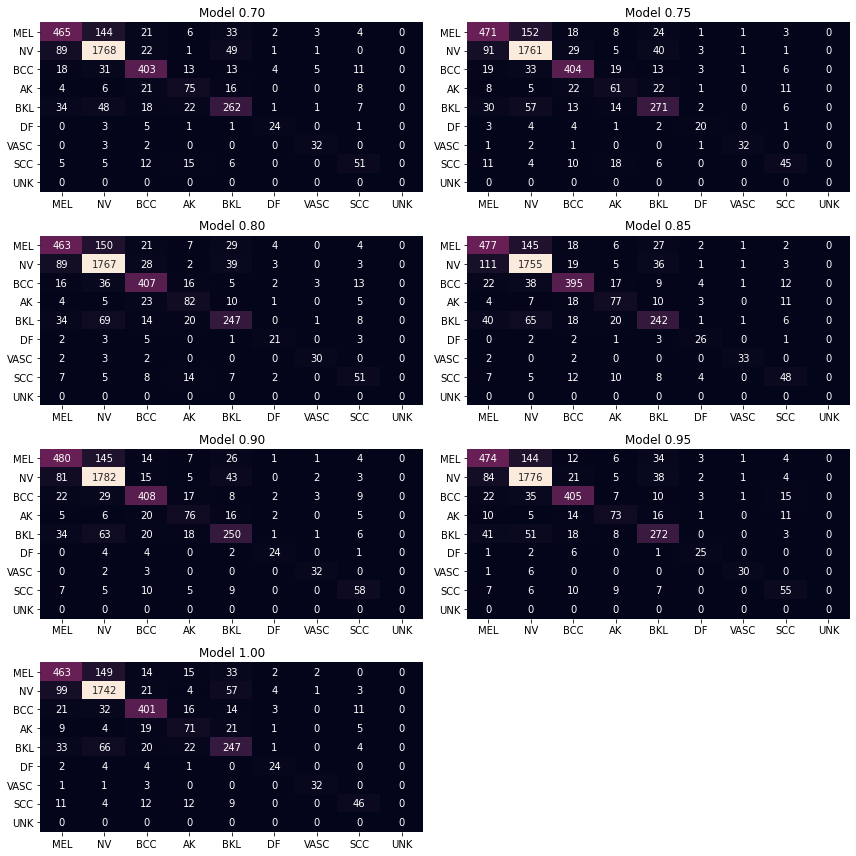

In [51]:
plt.figure(figsize=(12,12))
for i in range(no_models):
    ax = plt.subplot(4,2,i+1)
    predictions= model_preds[i] 
    y_pred=np.argmax(predictions[1],axis=1)
    cm = plot_cm(y_true,y_pred,[*classes]) # cm_df = pd.DataFrame(data=cm,columns=classnames,dtype='int')
    sns.heatmap(cm, annot=True, fmt="d",xticklabels=classnames,yticklabels=classnames, cbar=False) #xticklabels=classnames,
    ax.set_title('Model {:.2f}'.format(target_coverages[i]))
plt.tight_layout()
plt.show()

In [52]:
coverages = np.arange(0.5,1.05,0.05) # coverages
coverages.shape

(11,)

Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)
Selectivenet Rejected images: (1139,)


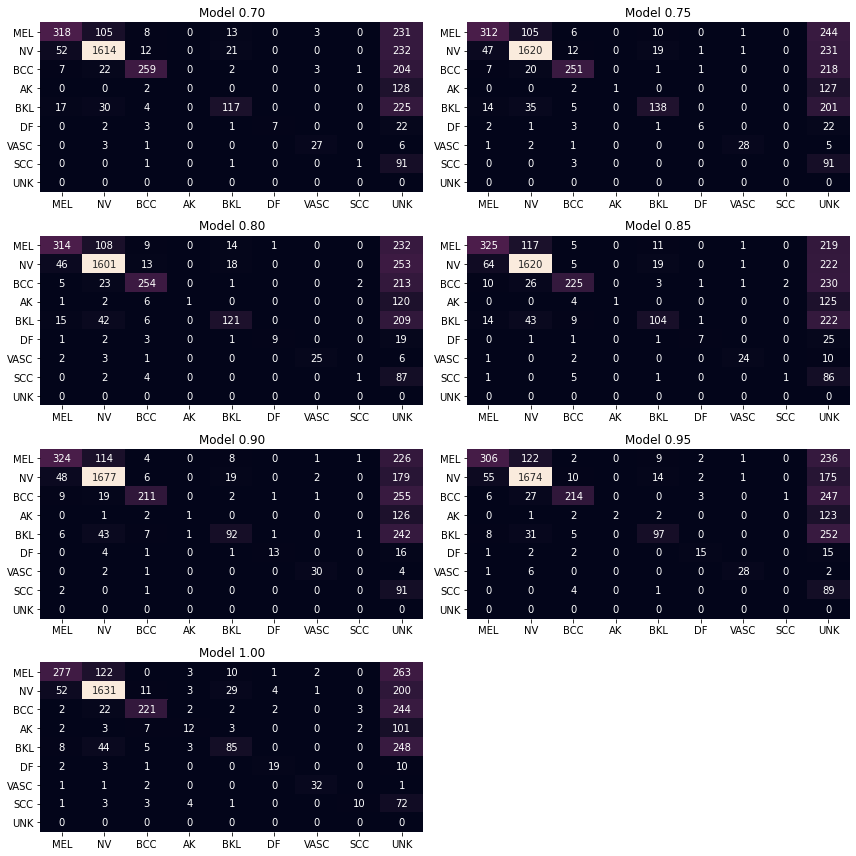

In [53]:
plt.figure(figsize=(12,12))
for i in range(no_models):
    ax = plt.subplot(4,2,i+1)
    predictions= model_preds[i] 
    y_pred=np.argmax(predictions[1],axis=1)
    covered_index = covered_idx(coverages[4],predictions[0][:,-1])
    y_pred[np.where(covered_index==False)[0]] = num_class -1
    print("Selectivenet Rejected images: {}".format(np.where(covered_index==False)[0].shape))
    cm = plot_cm(y_true,y_pred,[*classes])
    sns.heatmap(cm, annot=True, fmt="d",xticklabels=classnames,yticklabels=classnames,cbar=False) 
    ax.set_title('Model {:.2f}'.format(target_coverages[i]))
    
plt.tight_layout()
plt.show()

In [54]:
header =",".join(["model_no","sel_coverage", "sel_risk", 
                   "sel_accuracy","sr_coverage", "sr_risk", "sr_accuracy\n"])
rc_fname=save_dir+'/sel_risk_coverages3.csv'
# f=open(rc_fname,"w")
# f.write(header)
# f.close()

In [55]:
for j in range(no_models):
    predictions= model_preds[j]
    coverage_risk = np.zeros((coverages.shape[0],3), dtype = "float")
    model_no = np.full([coverages.shape[0],1],[j])
    i=0
    for c in coverages:
        coverage_risk[i] = selective_risk(c,test_labels,predictions[1],predictions[0][:,-1]) #coverage_risk[0]
        i=i+1

    sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
    i=0
    for c in coverages:
        sr_coverages_risk[i]= sr_selective_risk(c,test_labels,predictions[1],mc=True)
        i=i+1
    model_no.shape  
    model_risk_coverage = np.concatenate((model_no,coverage_risk,sr_coverages_risk),axis=1)
    metric=model_risk_coverage.astype('str')
    write_csv(rc_fname,metric)

### SR Predictions

In [63]:
sr_predictions= sr_model.predict(test_batch) #set predictions for use    

In [64]:
y_true = np.argmax(test_labels,axis=1)
sr_y_pred = np.argmax(sr_predictions,axis=1)

In [65]:
acc=my_evaluation(y_true,sr_y_pred)
print("Accuracy:",acc)

Accuracy: 0.7903055848261328


### SR confusion matrix

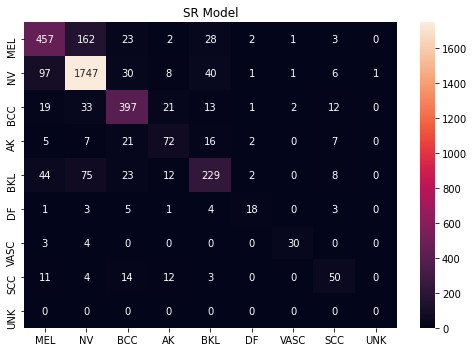

In [66]:
plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
cm = plot_cm(y_true,sr_y_pred,[*classes]) # cm_df = pd.DataFrame(data=cm,columns=classnames,dtype='int')
sns.heatmap(cm, annot=True, fmt="d",xticklabels=classnames,yticklabels=classnames) #xticklabels=classnames,
ax.set_title('SR Model')
plt.tight_layout()
plt.show()

SR Rejected images: (1140,)


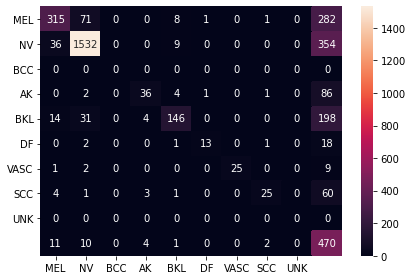

In [67]:
sr_covered = sr_covered_idx(coverages[4],y_true,sr_predictions)
sr_y_pred[np.where(sr_covered==False)[0]] = 2
print("SR Rejected images: {}".format(np.where(sr_covered==False)[0].shape))
cm = plot_cm(y_true,sr_y_pred,[*classes,2])
sns.heatmap(cm, annot=True, fmt="d",xticklabels=classnames,yticklabels=classnames) 
ax.set_title('SR Model')
plt.tight_layout()
plt.show()

In [68]:
sr_coverages_risk = np.zeros((coverages.shape[0],3), dtype = "float")
i=0
for c in coverages:
    sr_coverages_risk[i]= sr_selective_risk(c,test_labels,sr_predictions,mc=True)
    i=i+1

sr_coverages_risk    

array([[0.49973656, 0.05745915, 0.94254085],
       [0.54952582, 0.06663471, 0.93336529],
       [0.5995785 , 0.07513181, 0.92486819],
       [0.64963119, 0.08556367, 0.91443633],
       [0.69968388, 0.09902108, 0.90097892],
       [0.74973656, 0.11243851, 0.88756149],
       [0.79952582, 0.13311367, 0.86688633],
       [0.8495785 , 0.1503876 , 0.8496124 ],
       [0.89963119, 0.16925329, 0.83074671],
       [0.94968388, 0.18779473, 0.81220527],
       [0.99973656, 0.20974967, 0.79025033]])

### These plots were obtained at end of project

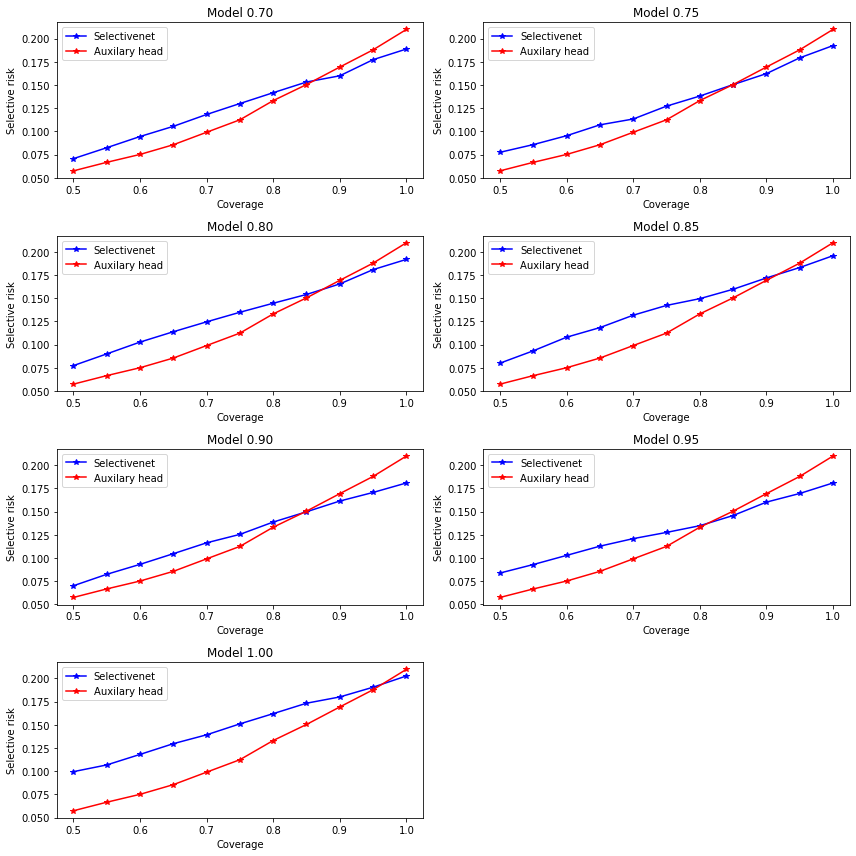

In [69]:
# target_coverages
plt.figure(figsize=(12,12))
for j in range(no_models):
    ax = plt.subplot(4,2,j+1)
    predictions= model_preds[j] 
    y_pred=np.argmax(predictions[1],axis=1)
    i=0
    for c in coverages:
        coverage_risk[i] = selective_risk(c,test_labels,predictions[1],predictions[0][:,-1])
        i=i+1
    ax.plot(coverages,coverage_risk[:,1],color='blue', linestyle='-',marker='*',label='Selectivenet')
    ax.plot(coverages,sr_coverages_risk[:,1],color='red', linestyle='-',marker='*',label='Auxilary head')
    ax.legend(loc="best")
    ax.set_xlabel('Coverage')
    ax.set_ylabel('Selective risk')    
    ax.set_title('Model {:.2f}'.format(target_coverages[j]))

plt.tight_layout()
plt.show()

### The following plots were the previous results obtained and used in report

In [115]:
lr_curve=pd.read_csv(rc_fname)
y = lr_curve[lr_curve['model_no']==0]
y.shape

(11, 7)

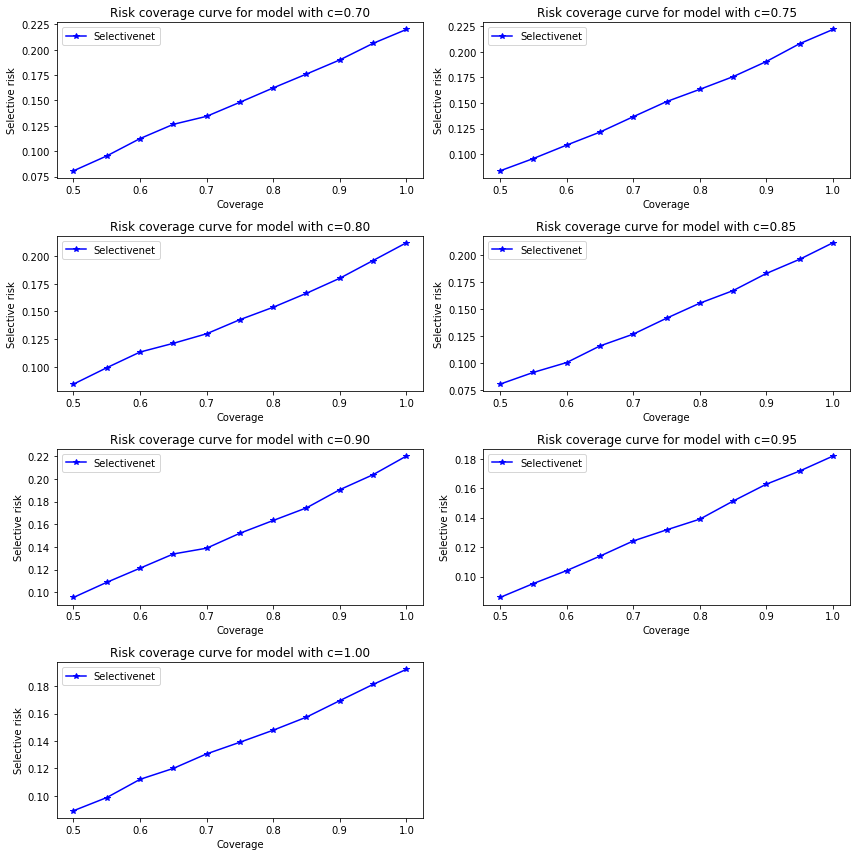

In [116]:
plt.figure(figsize=(12,12))
for i in range(7):
    ax = plt.subplot(4,2,i+1)
    y = lr_curve[lr_curve['model_no']==i]
    #     print(y.shape)
    ax.plot(coverages,y['sel_risk'],color='blue', linestyle='-',marker='*',label='Selectivenet')
#     ax.plot(coverages,y['sr_risk'],color='red', linestyle='-',marker='*',label='Auxilary head')
    ax.legend(loc="best")
    ax.set_xlabel('Coverage')
    ax.set_ylabel('Selective risk')
    ax.set_title('Risk coverage curve for model with c={:.2f}'.format(target_coverages[i]))
plt.tight_layout()
plt.show()

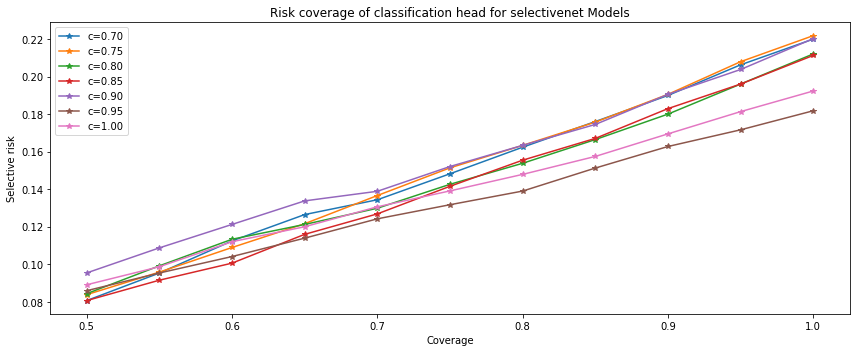

In [117]:
fig, ax =plt.subplots()
fig.set_size_inches(12,5)
for i in range(7):
    y = lr_curve[lr_curve['model_no']==i]
    ax.plot(coverages,y['sel_risk'], linestyle='-',marker='*',label='c={:.2f}'.format(target_coverages[i]))

ax.legend(loc="best")
ax.set_xlabel('Coverage')
ax.set_ylabel('Selective risk')
ax.set_title('Risk coverage of classification head for selectivenet Models')

plt.tight_layout()
plt.show()

In [118]:
metric=sr_coverages_risk.astype('str')
# write_csv(rc_sr_fname,metric)

In [119]:
sr_curve=pd.read_csv(rc_sr_fname)

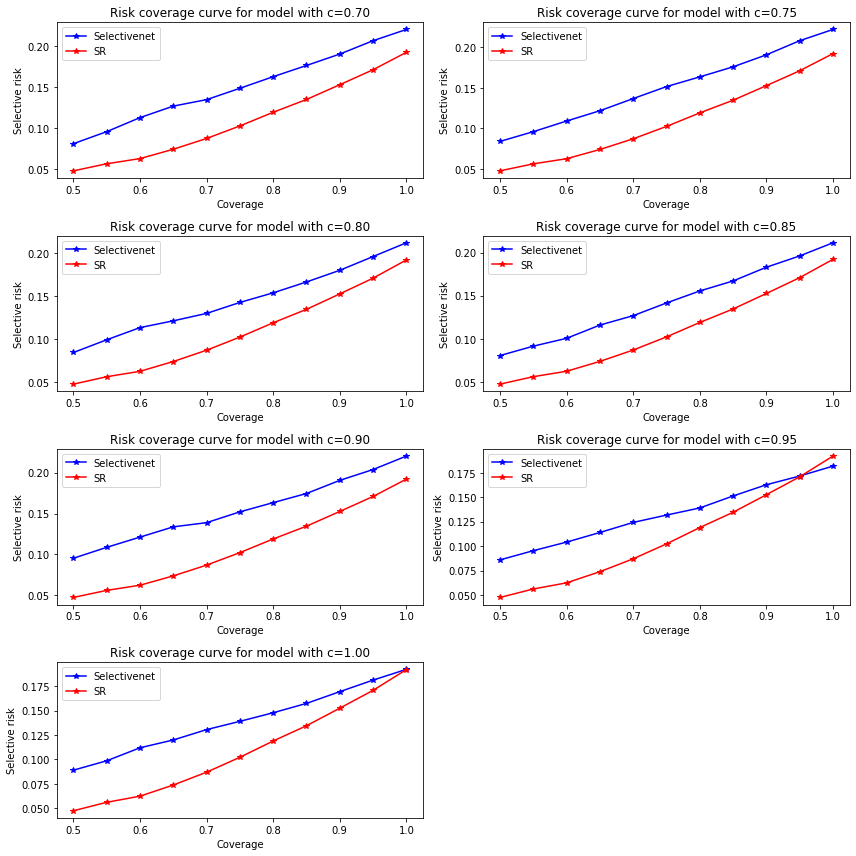

In [120]:
cal_coverages = np.arange(0.7,1.0,0.05)
plt.figure(figsize=(12,12))
c= np.arange(0.7,1.05,0.05)
for i in range(7):
    ax = plt.subplot(4,2,i+1)
    y = lr_curve[lr_curve['model_no']==i]
    ax.plot(coverages,y['sel_risk'],color='blue', linestyle='-',marker='*',label='Selectivenet')
    ax.plot(coverages,sr_curve['sr_risk'],color='red', linestyle='-',marker='*',label='SR')
    ax.legend(loc="best")
    ax.set_xlabel('Coverage')
    ax.set_ylabel('Selective risk')
    ax.set_title('Risk coverage curve for model with c={:.2f}'.format(c[i]))
plt.tight_layout()
plt.show()